## Imports

In [1]:
# Standard
import json
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Models
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import RandomOverSampler

# Scoring
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


## Data

In [3]:
file_name = 'gb'
df = pd.read_pickle(f'..\\processed_data\\{file_name}.pki')

In [4]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status,TotalIncome,EMI,BalanceIncome
0,LP001002,1,0,0,0,0,1.0,2,1,5849.0,0.347222,5848.652778
1,LP001003,1,1,1,0,0,1.0,0,0,6091.0,0.355556,6090.644444
2,LP001005,1,1,0,0,1,1.0,2,1,3000.0,0.183333,2999.816667
3,LP001006,1,1,0,1,0,1.0,2,1,4941.0,0.333333,4940.666667
4,LP001008,1,0,0,0,0,1.0,2,1,6000.0,0.391667,5999.608333


In [5]:
r = random.randint(1, 100)
train, test = train_test_split(df, test_size=.25, random_state=14)

In [6]:
X = train.drop(['Loan_ID', 'Loan_Status'], axis = 1)
y = train['Loan_Status']
print(X.head())
print(y.head())

     Gender  Married Dependents  Education  Self_Employed  Credit_History  \
132       1        0          0          0              0             1.0   
609       0        0          0          0              0             1.0   
557       1        1          3          0              1             1.0   
90        1        1          0          0              0             1.0   
377       1        1          0          0              0             1.0   

     Property_Area  TotalIncome       EMI  BalanceIncome  
132              1       2718.0  0.194444    2717.805556  
609              0       2900.0  0.197222    2899.802778  
557              1      10139.0  0.722222   10138.277778  
90               1       5858.0  0.363889    5857.636111  
377              1       4310.0  0.361111    4309.638889  
132    1
609    1
557    1
90     1
377    1
Name: Loan_Status, dtype: int32


In [7]:
y.value_counts()

Loan_Status
1    300
0    137
Name: count, dtype: int64

## Hyper-parameter training Extra Trees

In [8]:
# Find the Best Model
param_grid = {
    'n_estimators': [_ for _ in range(100, 501, 100)],
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease': [.1, .25, .3, .35],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(ExtraTreesClassifier(), param_grid=param_grid, cv=5,scoring='f1_weighted', verbose=5, n_jobs=-1)
grid_search.fit(X, y)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5, estimator=ExtraTreesClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'min_impurity_decrease': [0.1, 0.25, 0.3, 0.35],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='f1_weighted', verbose=5)

## Bagging

In [9]:
base_model = grid_search.best_estimator_

In [10]:
r = random.randint(1, 101)
model = BaggingClassifier(estimator=base_model, n_estimators=500, bootstrap_features=True, random_state=r, n_jobs=-1)

In [17]:
model.fit(X, y)

BaggingClassifier(bootstrap_features=True,
                  estimator=ExtraTreesClassifier(min_impurity_decrease=0.1,
                                                 n_estimators=300),
                  n_estimators=500, n_jobs=-1, random_state=28)

## Scoring

In [12]:
X_test, y_test = test.drop(columns=['Loan_ID', 'Loan_Status']), test['Loan_Status']

In [13]:
y_pred = model.predict(X_test)

In [16]:
f1_score(y_pred = y_pred, y_true=y_test)

0.0

In [15]:
accuracy_score(y_pred = y_pred, y_true=y_test)

0.2945205479452055

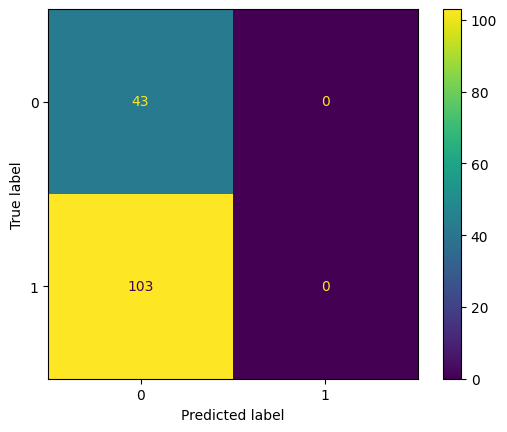

In [18]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_pred = y_pred, y_true=y_test), display_labels=model.classes_)
disp.plot()
plt.show()